<a href="https://colab.research.google.com/github/ahhyun-moon/cs-gy-6613-assignments/blob/main/sports_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
# Download football-video.mp4 from G-Drive
# !gdown 1RHjI-dtvrqGgnhIstB2d2ol-nTHvNUiE # Original Source
!gdown 1T2SXTUlmnyN_YPo0ow98N_3zborQFWfZ # Saved in my G-Drive
# Video for testing (3s long)
# !gdown 10bClW5rzvYATErpHMrgITd61ESBnkpzd
# Deepsort
# Download customized DEEPSORT lib from G-Drive
!gdown 1n6CPo6ZXgcfLgSYCF5GMxK21oh7p0FFc
!unzip /content/customized_deep_sort.zip
# Install DEEPSORT dependencies
!pip install numpy opencv-python scikit-learn 
!rm -r /content/__MACOSX
# Download mars-small128.pb weights from G-Drive
!gdown 1rENhTdPNXQqVosm3JgziEqjlCYXahvVu

Downloading...
From: https://drive.google.com/uc?id=1n6CPo6ZXgcfLgSYCF5GMxK21oh7p0FFc
To: /content/customized_deep_sort.zip
100% 197k/197k [00:00<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rENhTdPNXQqVosm3JgziEqjlCYXahvVu
To: /content/mars-small128.pb
100% 11.2M/11.2M [00:00<00:00, 102MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1T2SXTUlmnyN_YPo0ow98N_3zborQFWfZ
To: /content/football-video.mp4
100% 6.41M/6.41M [00:00<00:00, 72.4MB/s]


In [6]:
# Import necessary libraries
import numpy as np
import cv2
import torch
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib
from google.colab.patches import cv2_imshow
from customized_deep_sort.deep_sort import nn_matching
from customized_deep_sort.application_util import preprocessing
from customized_deep_sort.deep_sort.tracker import Tracker
from customized_deep_sort.deep_sort.detection import Detection
from customized_deep_sort.tools import generate_detections

In [11]:
# Define COCO dataset class names given by PyTorch's official Docs
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [36]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load pretrained Faster-RCNN                   
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True).eval().to(device)
transform = transforms.Compose([transforms.ToTensor()])                                 
# Prepare metrics for DEEPSORT 
max_cosine_distance = 0.5
nms_max_overlap = 0.3
nn_budget = None
metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
# Initialize DEEPSORT tracker and encoder
tracker = Tracker(metric)
model_filename = '/content/mars-small128.pb'
encoder = generate_detections.create_box_encoder(model_filename,batch_size=1)
# Prepare video file for analytics and output format
filename = '/content/football-video.mp4'
cap = cv2.VideoCapture(filename)
fourcc = cv2.VideoWriter_fourcc('F','M','P','4')
out = cv2.VideoWriter('/content/result_video.mp4',fourcc, 20, (1280,720))

In [37]:
while(True):
    try:
      is_success, frame = cap.read()
    except cv2.error:
      continue
    if not is_success:
      break
    # Model
    threshold = 0.75
    # Load/transform/predict incoming frame
    pred = model([transform(Image.fromarray(frame)).to(device)])
    # Convert prediction to numpy
    pred_score = list(pred[0]['scores'].cpu().detach().numpy())   
    # Filter scores according threshold
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    # Store detection results - labels, boxes, scores
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())][:pred_t+1]        # filter classes within the threshold
    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(pred[0]['boxes'].cpu().detach().numpy())][:pred_t+1]   # filter boxes within the threshold                                    
    pred_score = list(pred[0]['scores'].cpu().detach().numpy())[:pred_t+1]
    bboxes = []
    scores = []
    # Preprocess detection results before passing to tracking (DEEPSORT)
    for i, p in enumerate(pred_boxes):
      if(pred_score[i] > threshold):
        bbox_left = min(p[0], p[2])
        bbox_top = min(p[1], p[3])
        bbox_w = abs(p[0] - p[2])
        bbox_h = abs(p[1] - p[3])
        box = [bbox_left, bbox_top, bbox_w, bbox_h]
        bboxes.append(box)
        scores.append(pred_score[i])
    # Extract features based on detected boxes
    features = encoder(frame,bboxes)
    # Prepare boxes into detection objects before updating tracker
    detections = [Detection(bbox, score, feature) for bbox, score, feature in zip(bboxes, scores, features)]
    # Call the tracker and update the detections
    tracker.predict()
    tracker.update(detections)
    # For each tracked result:
    ## Draw rectangle and put id
    for track in tracker.tracks:
      if not track.is_confirmed() or track.time_since_update > 1:
        continue
      bbox = track.to_tlbr()
      cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255, 255, 255), 2)
      cv2.putText(frame, str(track.track_id), (int(bbox[0]), int(bbox[1])), 0, 5e-3 * 200, (0, 255, 0), 2)
    # Display the resulting frame
    # cv2_imshow(frame)
    # Write to video ouput
    out.write(frame)
    # Quit writing if q is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# Release the output file
out.release()
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Downloading...
From: https://drive.google.com/uc?id=1AeA6kSK6NQ_q9a9iGQ0XCt4qDfJysm-a
To: /content/sports_analytics_example.png
100% 2.92M/2.92M [00:00<00:00, 226MB/s]


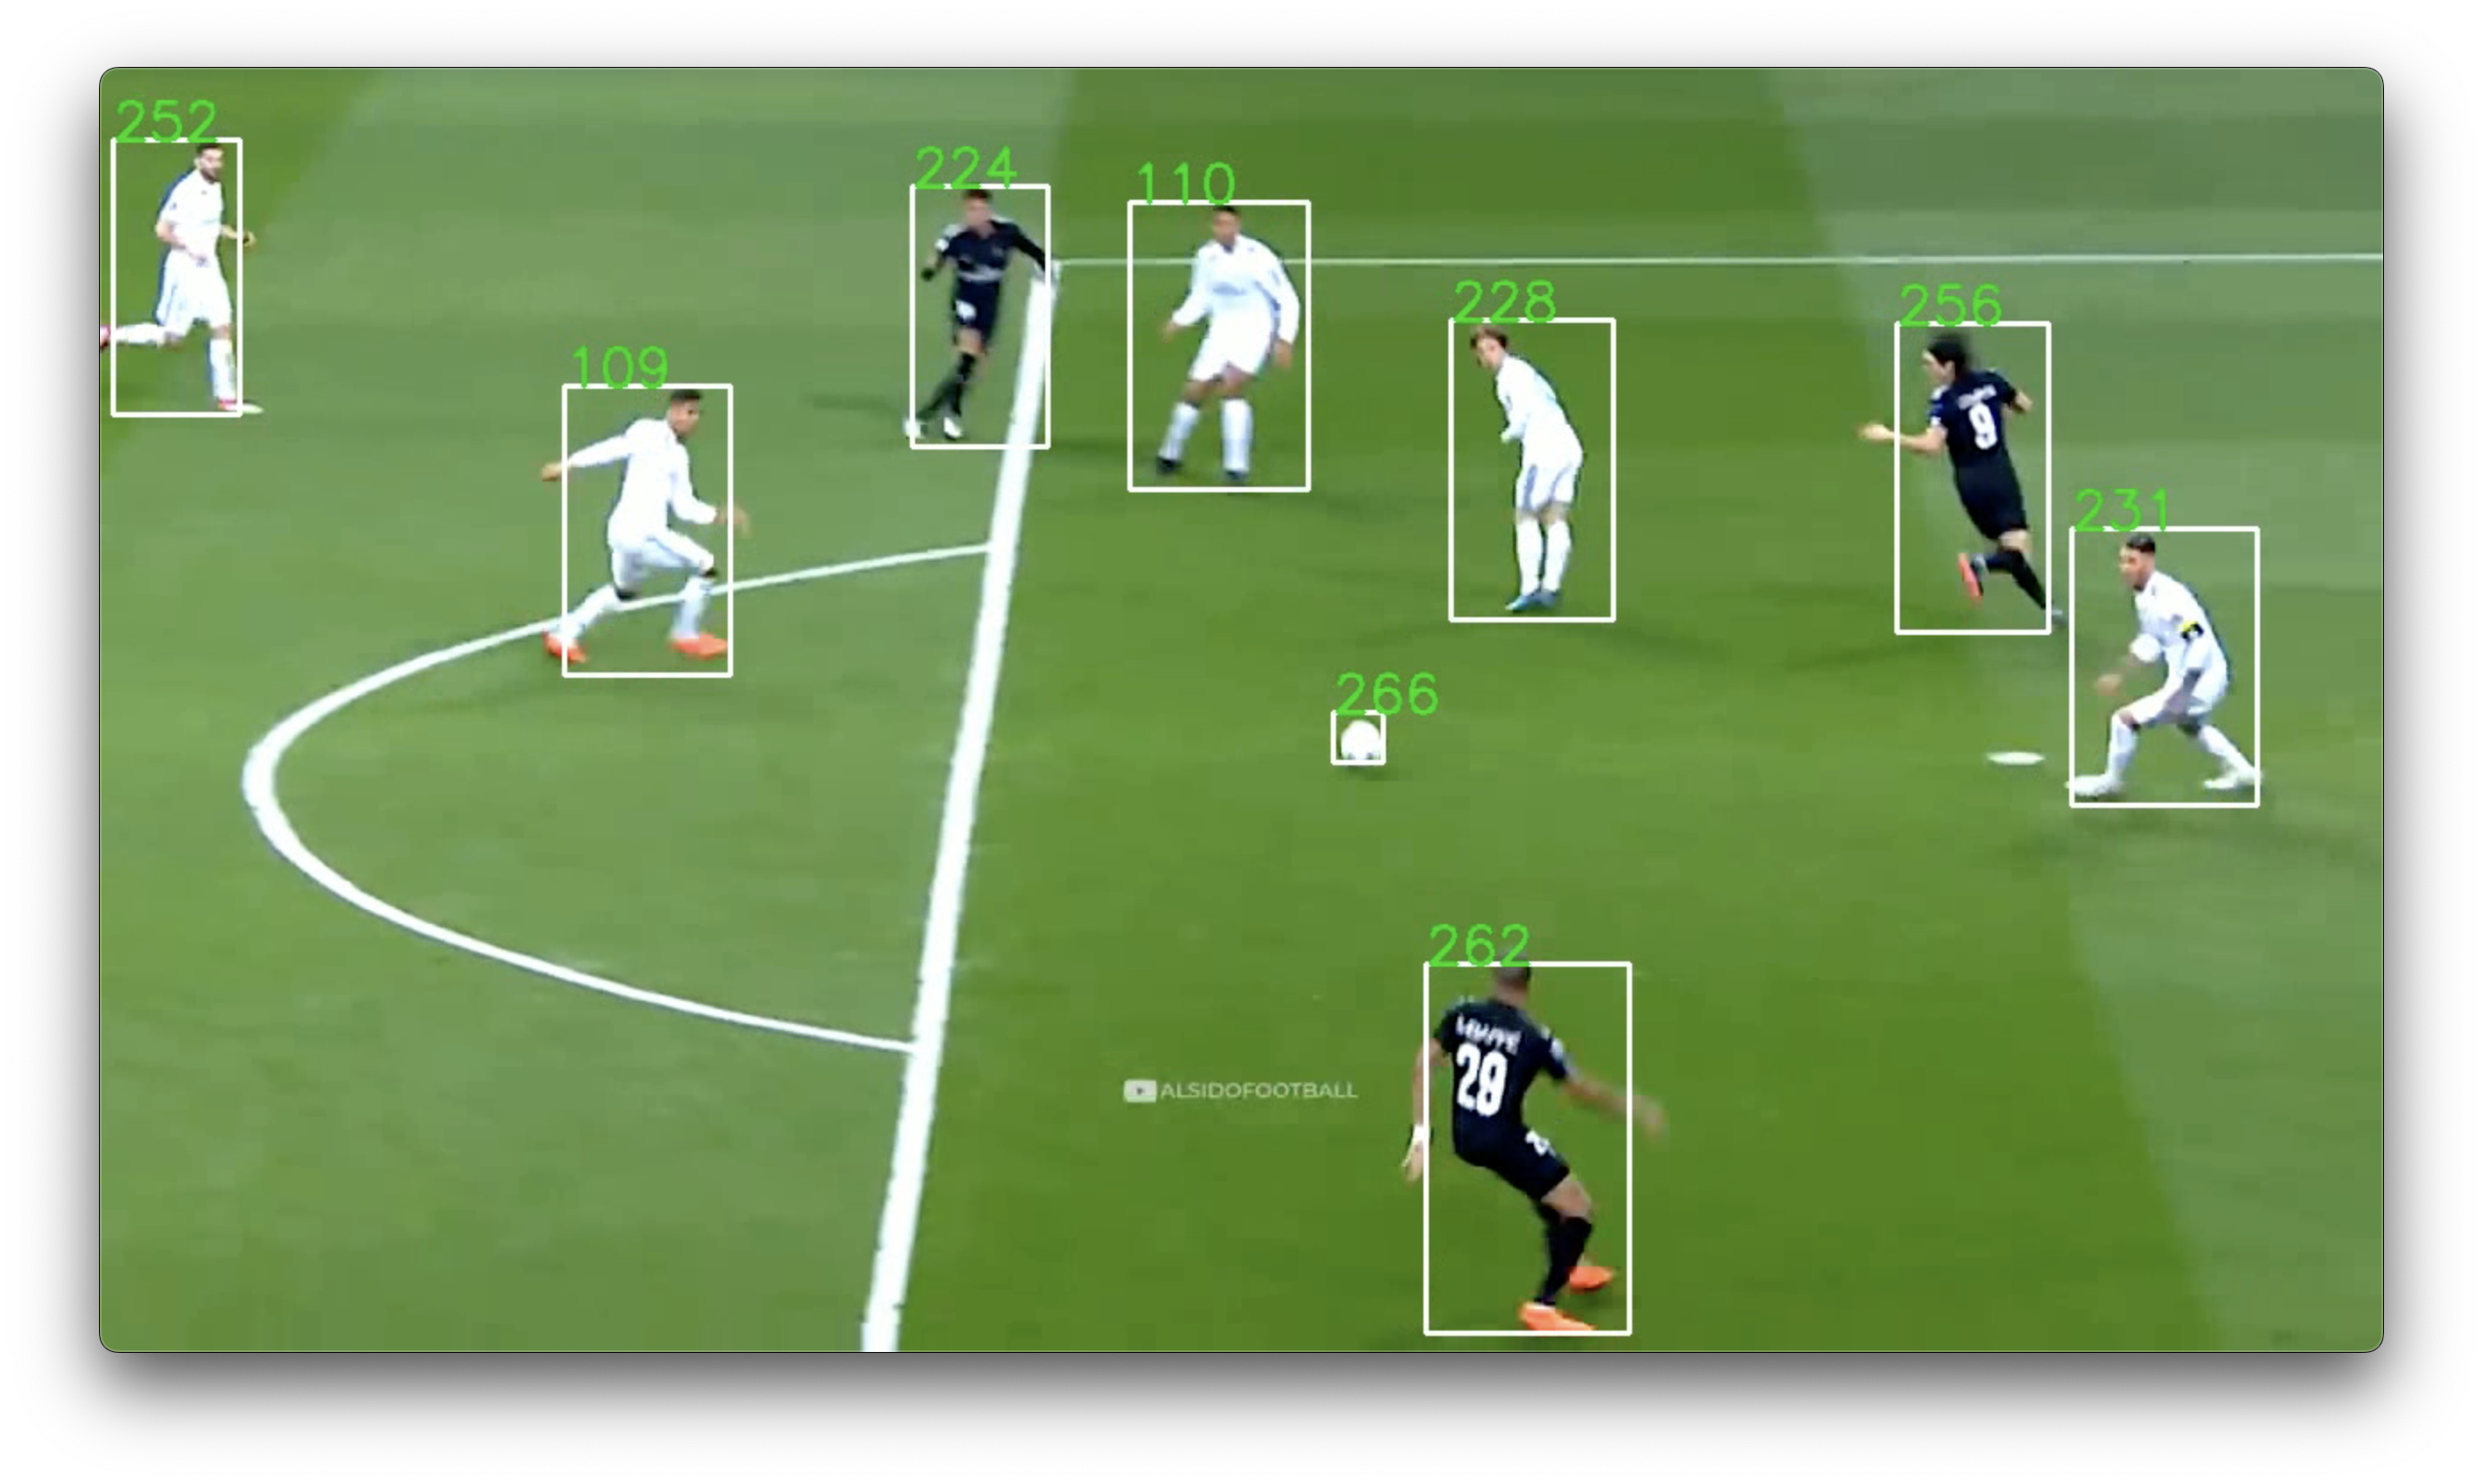

In [41]:
# Video frame example
!gdown 1AeA6kSK6NQ_q9a9iGQ0XCt4qDfJysm-a
img = cv2.imread('/content/sports_analytics_example.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)